### Steps to be Taken
1. Load raw data
2. Basic Cleaning
3. Schema Joins
4. Aggregation
5. Encoding
6. Main cleaning
7. Outlier handling (Log Transformation)

In [116]:
# Import necessary libraries

import pandas as pd  # Data preprocessing
import numpy as np
import matplotlib.pyplot as plt  # Data viz
import seaborn as sns # Data viz
import missingno as msno #Missing data - Data visualisation
import collections as Counter  # Counting

In [62]:
# Load your csv files

claims = pd.read_csv("claims.csv")
policyholders = pd.read_csv("policyholders.csv")
thirdparty = pd.read_csv("third_parties.csv")



### Inspect Datasets

In [63]:
# inspect data set
                        
claims.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,Minor,2020-03-01,settled
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,Minor,2019-03-23,settled
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,False,False,153631,156497.0,Catastrophic,2022-04-22,settled
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,False,False,2812,1450.0,Minor,2021-09-13,settled
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,False,False,5094,4243.0,Minor,2021-05-26,settled


In [64]:
policyholders.head()

,Policy_ID,Customer_ID,Age_of_Driver,Gender,Occupation,Region,Annual_Mileage,Driving_Experience_Years,Vehicle_Type,Vehicle_Age,Credit_Score_Band
0,POL10000,CUST20000,56,Female,Retired,Newcastle,7552,36,Sedan,10,Fair
1,POL10001,CUST20001,53,Female,Unemployed,Bristol,13275,31,Motorcycle,11,Poor
2,POL10002,CUST20002,19,Female,Unemployed,London,12967,0,Sedan,9,Excellent
3,POL10003,CUST20003,77,Female,Retired,Birmingham,4346,56,Hatchback,2,Fair
4,POL10004,CUST20004,24,Male,Employed,Manchester,9598,2,Sedan,14,Good


In [65]:
thirdparty.head()


,Claim_ID,TP_ID,ThirdParty_Role,TP_Injury_Severity
0,CLM30000,TP40000,Pedestrian,Minor
1,CLM30002,TP40001,Passenger,Minor
2,CLM30007,TP40002,Pedestrian,Minor
3,CLM30012,TP40003,Pedestrian,Minor
4,CLM30015,TP40004,Driver,Minor


### Basic Cleaning 

In [66]:
# fix date datatype
claims["Accident_Date"] = pd.to_datetime(claims["Accident_Date"])
claims["FNOL_Date"] = pd.to_datetime(claims["FNOL_Date"])
claims["Settlement_Date"] = pd.to_datetime(claims["Settlement_Date"])

In [67]:
claims.dtypes

Claim_ID                          object
Policy_ID                         object
Accident_Date             datetime64[ns]
FNOL_Date                 datetime64[ns]
Claim_Type                        object
Claim_Complexity                  object
Fraud_Flag                          bool
Litigation_Flag                     bool
Estimated_Claim_Amount             int64
Ultimate_Claim_Amount            float64
Severity_Band                     object
Settlement_Date           datetime64[ns]
Status                            object
dtype: object

In [68]:
# Removing exact duplicates because they do not contain any extra information

claims = claims.drop_duplicates()
policyholders = policyholders.drop_duplicates()
thirdparty = thirdparty.drop_duplicates()

In [69]:
# Standadise category labels
'''Before encoding, text must be consistent. this prevents "minor" vs "Minor" or 
" Serious " vs "Serious" '''

thirdparty["TP_Injury_Severity"] = (
    thirdparty["TP_Injury_Severity"]
    .str.strip()
    .str.title()
)

In [70]:
# Chech for missing IDs
''' The purpose of this is to know them and decide how to later handle it'''

claims["Claim_ID"].isna().sum()
policyholders["Policy_ID"].isna().sum()
thirdparty["Claim_ID"].isna().sum()

np.int64(0)

In [71]:
# Check for impossible values

policyholders.loc[policyholders["Age_of_Driver"] < 16]
policyholders.loc[policyholders["Vehicle_Age"] <0]

,Policy_ID,Customer_ID,Age_of_Driver,Gender,Occupation,Region,Annual_Mileage,Driving_Experience_Years,Vehicle_Type,Vehicle_Age,Credit_Score_Band


### Schema Mapping

In [72]:
# Claim_id - Thirdparty (one-to-many)
# This join ensures thirdparty information is attached to claims

'''Left join is used to ensure all claims are kept, adds thirdparty data only where it exists
and claims with no third party gets NaN'''

claims_tp = claims.merge(
    thirdparty,
    on="Claim_ID",
    how="left"
)

In [73]:
# Policy_ID - Policyholder

claims_tp_ph = claims_tp.merge(
    policyholders,
    on="Policy_ID",
    how="left"
)

In [74]:
# final dataset.
'''Here we have claims, policyholder features and third-party severity'''

claims_tp_ph.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,...,Customer_ID,Age_of_Driver,Gender,Occupation,Region,Annual_Mileage,Driving_Experience_Years,Vehicle_Type,Vehicle_Age,Credit_Score_Band
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,...,CUST24506,53,Female,Retired,Glasgow,4891,34,Hatchback,6,Excellent
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,...,CUST24338,43,Female,Employed,Newcastle,18408,23,Van,9,Fair
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,False,False,153631,156497.0,...,CUST23575,19,Female,Unemployed,Newcastle,10793,0,SUV,5,Excellent
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,False,False,2812,1450.0,...,CUST20138,26,Male,Employed,Newcastle,9405,5,Hatchback,13,Good
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,False,False,5094,4243.0,...,CUST22316,27,Female,Unemployed,Leeds,16729,9,Hatchback,12,Excellent


In [75]:
claims_tp_ph.dtypes

Claim_ID                            object
Policy_ID                           object
Accident_Date               datetime64[ns]
FNOL_Date                   datetime64[ns]
Claim_Type                          object
Claim_Complexity                    object
Fraud_Flag                            bool
Litigation_Flag                       bool
Estimated_Claim_Amount               int64
Ultimate_Claim_Amount              float64
Severity_Band                       object
Settlement_Date             datetime64[ns]
Status                              object
TP_ID                               object
ThirdParty_Role                     object
TP_Injury_Severity                  object
Customer_ID                         object
Age_of_Driver                        int64
Gender                              object
Occupation                          object
Region                              object
Annual_Mileage                       int64
Driving_Experience_Years             int64
Vehicle_Typ

### Aggregation and Encoding 

1. Aggregation: Collapsing many third-party rows into one claim-level summary
2. Encoding: Turning categorical data to numerical data

These steps are important to produce features the model can actually use. 

Ordinal Encoding was used because injury severity has a natural order and the numbers help preserve that order. it preserves ordering and meaning.

In [84]:
# Encoding injury severity
# This is done before aggregation because you cannot take the max or mean of texts.

''' Text categories are converted to numbers (fatal, serious, minor) 
and a new column is created to be used for calculations''' 


severity_map = {
    "Minor": 1,
    "Serious": 2,
    "Fatal": 3
}


claims_tp["TP_Severity_Score"] = (
    claims_tp["TP_Injury_Severity"]
    .astype(str)
    .str.strip()
    .str.title()
    .map(severity_map)
)

### Aggregate to Claim Level

In [77]:
# All thirdparties for a claim are collapsed into one summary row. 


''' Num_Third_Parties: exposure size
    Max_TP_Severity: worse injury on the claim
    Avg_TP_Severity: overall injury intensity '''

tp_agg = (
    claims_tp
    .groupby("Claim_ID", as_index=False)
    .agg(
        Num_Third_Parties=("TP_ID", "count"),
        Max_TP_Severity=("TP_Severity_Score", "max"),
        Avg_TP_Severity=("TP_Severity_Score", "mean")
    )
)


In [78]:
# Merge back to the claims table
# This reattaches thirdparty summaries to original claims
# This table will be used by the model

claims_claim_level = claims.merge(
    tp_agg,
    on="Claim_ID",
    how="left"
)


In [79]:
# Fill safe defaults
''' claims with no third parties get Zero '''

claims_claim_level["Num_Third_Parties"] = claims_claim_level["Num_Third_Parties"].fillna(0)
claims_claim_level["Max_TP_Severity"] = claims_claim_level["Max_TP_Severity"].fillna(0)
claims_claim_level["Avg_TP_Severity"] = claims_claim_level["Avg_TP_Severity"].fillna(0)



In [85]:
# Sanity Check

''' This confirms the following:
    No duplication
    Aggregation worked
    the model is appropriate '''

print("Rows:", claims_claim_level.shape[0])
print("Unique Claim_ID:", claims_claim_level["Claim_ID"].nunique())




Rows: 8000
Unique Claim_ID: 8000


In [86]:
claims_claim_level.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,Minor,2020-03-01,settled,1,1.0,1.0
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,Minor,2019-03-23,settled,0,0.0,0.0
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,False,False,153631,156497.0,Catastrophic,2022-04-22,settled,1,1.0,1.0
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,False,False,2812,1450.0,Minor,2021-09-13,settled,0,0.0,0.0
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,False,False,5094,4243.0,Minor,2021-05-26,settled,0,0.0,0.0


In [89]:
claims_claim_level.dtypes


Claim_ID                          object
Policy_ID                         object
Accident_Date             datetime64[ns]
FNOL_Date                 datetime64[ns]
Claim_Type                        object
Claim_Complexity                  object
Fraud_Flag                          bool
Litigation_Flag                     bool
Estimated_Claim_Amount             int64
Ultimate_Claim_Amount            float64
Severity_Band                     object
Settlement_Date           datetime64[ns]
Status                            object
Num_Third_Parties                  int64
Max_TP_Severity                  float64
Avg_TP_Severity                  float64
dtype: object

#### Explainations

1. The model will now use "claims_claim_level" dataset because thirdparty information have been joined to claims to  calculate severity features and then aggregated back to row per claim before modelling. this avoids duplication bias.

2. claims_claim_level has fewer columns than claims_tp_ph because third-party columns have been collapsed into summary features.


3. claims_tp_ph contains 

All claim columns

All policyholder columns

Raw third-party columns, e.g.:

TP_ID

TP_Injury_Severity

ThirdParty_Role

All of these TP colums exists because each role represents an individual thirdparty. 


4. However, claims_claim_level is a summary table that contains 
Claim-level columns

Policy-level columns

Aggregated third-party features, e.g.:

Num_Third_Parties

Max_TP_Severity

Avg_TP_Severity


It no longer contails 
TP_ID

Individual injury rows

Third-party roles

Because those no longer make sense at claim level.

After the aggregation, there is no longer a thirdparty, only summary of thirdparties.


## Claim Level Cleaning

In [93]:
claims_claim_level.shape

(8000, 16)

In [91]:
claims_claim_level.info()

# There are missing values in the Ultimate_Claim_Amount and Settlement_Date columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Claim_ID                8000 non-null   object        
 1   Policy_ID               8000 non-null   object        
 2   Accident_Date           8000 non-null   datetime64[ns]
 3   FNOL_Date               8000 non-null   datetime64[ns]
 4   Claim_Type              8000 non-null   object        
 5   Claim_Complexity        8000 non-null   object        
 6   Fraud_Flag              8000 non-null   bool          
 7   Litigation_Flag         8000 non-null   bool          
 8   Estimated_Claim_Amount  8000 non-null   int64         
 9   Ultimate_Claim_Amount   7575 non-null   float64       
 10  Severity_Band           8000 non-null   object        
 11  Settlement_Date         7575 non-null   datetime64[ns]
 12  Status                  8000 non-null   object  

In [94]:
Numerical Statistical Analysis

claims_claim_level.describe()


,Accident_Date,FNOL_Date,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity
count,8000,8000,8.000000e+03,7.575000e+03,7575,8000.000000,8000.000000,8000.000000
mean,2022-04-02 01:52:51.600000,2022-04-03 20:20:45.600000256,1.447988e+04,1.311868e+04,2022-07-15 14:21:54.534653440,0.301250,0.295375,0.288438
min,2018-09-19 00:00:00,2018-09-19 00:00:00,5.500000e+02,3.320000e+02,2018-10-25 00:00:00,0.000000,0.000000,0.000000
25%,2020-06-20 00:00:00,2020-06-22 18:00:00,2.205750e+03,1.578000e+03,2020-10-11 12:00:00,0.000000,0.000000,0.000000
50%,2022-04-06 00:00:00,2022-04-07 00:00:00,4.416000e+03,3.409000e+03,2022-07-14 00:00:00,0.000000,0.000000,0.000000
75%,2024-01-05 00:00:00,2024-01-06 12:00:00,1.167475e+04,9.744000e+03,2024-04-17 00:00:00,0.000000,0.000000,0.000000
max,2025-09-17 00:00:00,2025-09-22 00:00:00,1.064239e+06,1.005590e+06,2027-03-29 00:00:00,2.000000,3.000000,3.000000
std,NaN,NaN,3.873981e+04,3.810405e+04,NaN,0.560168,0.551513,0.531326


In [97]:
# Investigate missing values

null_vals = claims_claim_level.isnull().sum()
null_vals

Claim_ID                    0
Policy_ID                   0
Accident_Date               0
FNOL_Date                   0
Claim_Type                  0
Claim_Complexity            0
Fraud_Flag                  0
Litigation_Flag             0
Estimated_Claim_Amount      0
Ultimate_Claim_Amount     425
Severity_Band               0
Settlement_Date           425
Status                      0
Num_Third_Parties           0
Max_TP_Severity             0
Avg_TP_Severity             0
dtype: int64

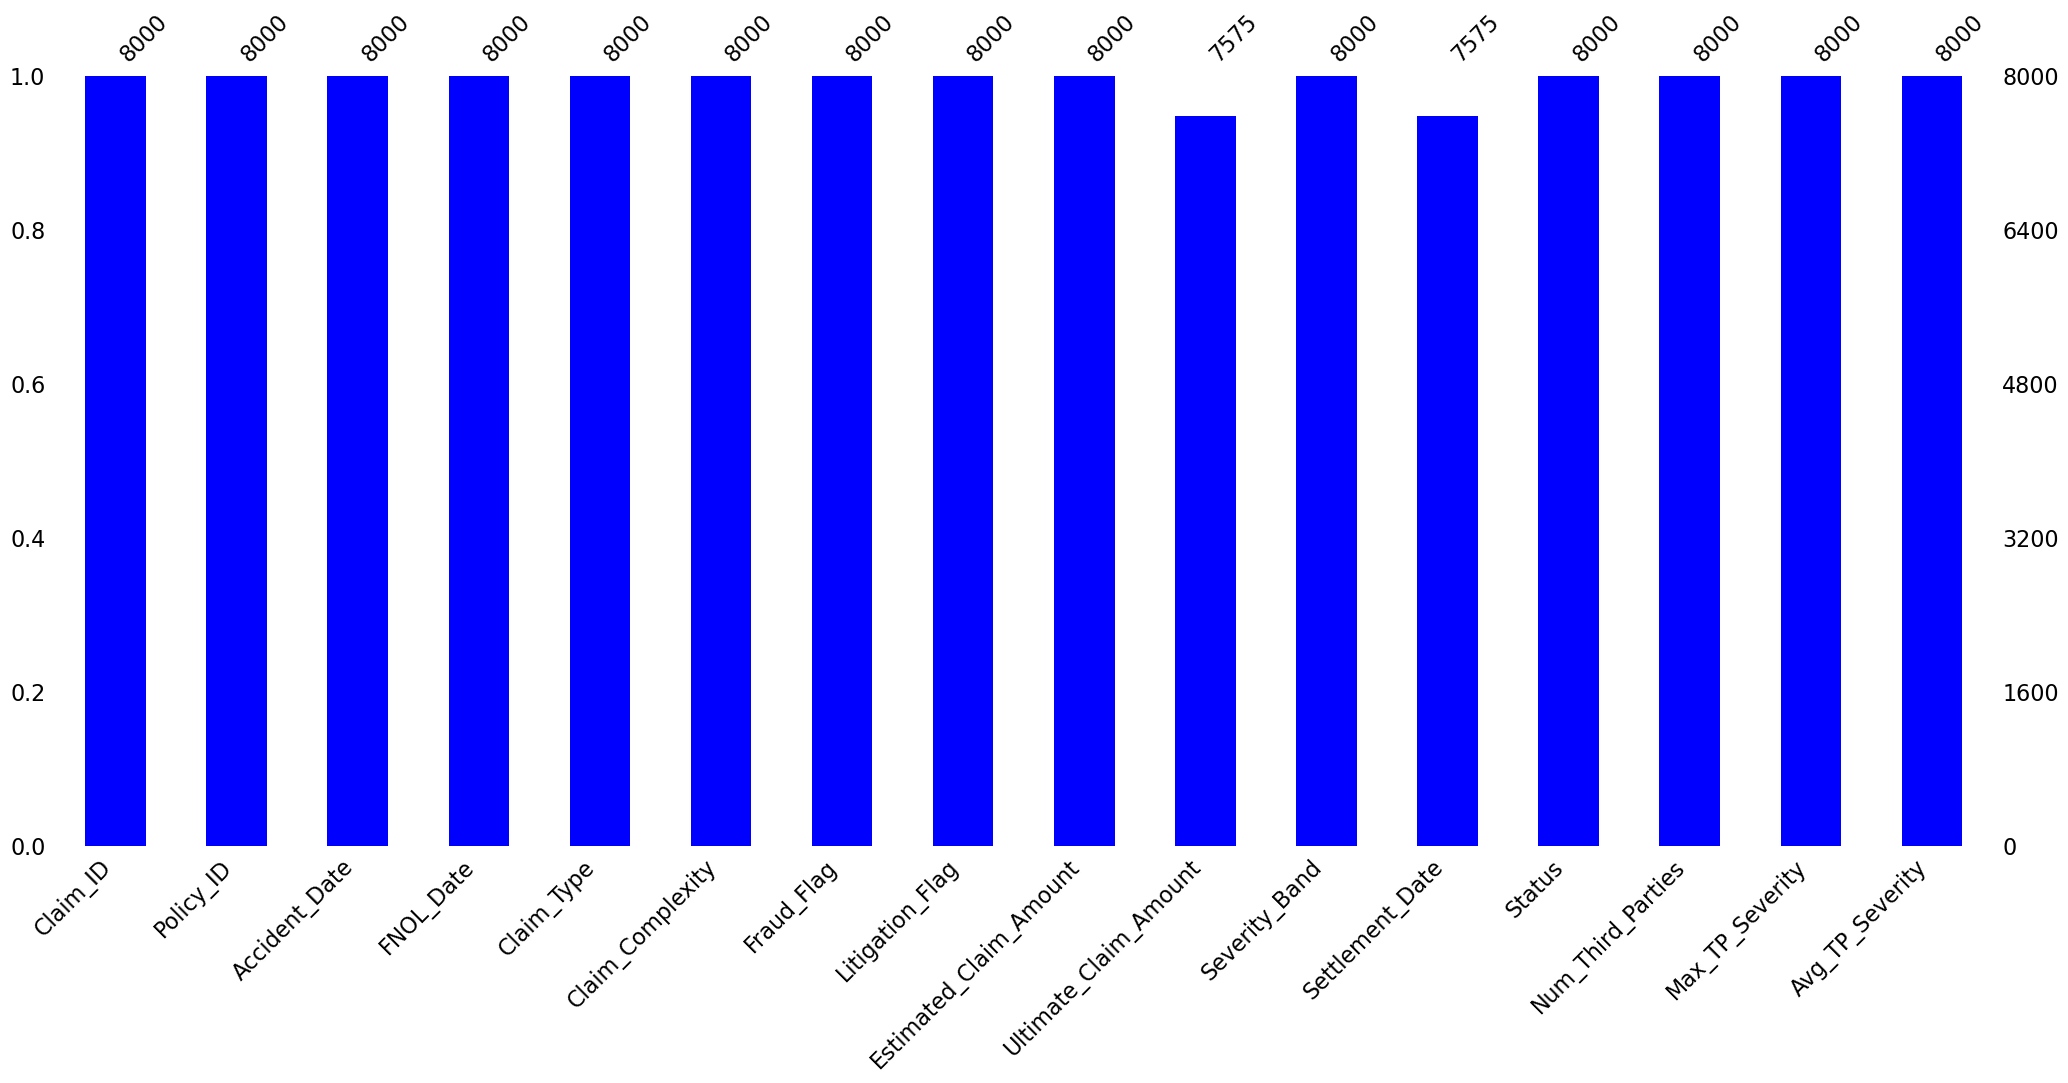

In [99]:
# Visualize missing data
msno.bar(claims_claim_level, color="blue");

In [101]:
# Display where missing data exists
claims_claim_level[claims_claim_level.isnull().any(axis=1)]

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity
53,CLM30053,POL11567,2025-03-10,2025-03-12,Fire,Low,False,False,36763,NaN,Moderate,NaT,open,0,0.0,0.0
86,CLM30086,POL14544,2022-04-03,2022-04-05,Collision,Medium,False,False,3671,NaN,Moderate,NaT,open,0,0.0,0.0
93,CLM30093,POL10238,2021-02-05,2021-02-07,Theft,Low,False,False,4751,NaN,Minor,NaT,open,0,0.0,0.0
94,CLM30094,POL10630,2024-04-24,2024-04-29,Collision,Low,False,False,3884,NaN,Moderate,NaT,open,0,0.0,0.0
96,CLM30096,POL11836,2023-11-11,2023-11-18,Vandalism,Low,False,False,5172,NaN,Major,NaT,open,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7857,CLM37857,POL10707,2023-07-04,2023-07-04,Fire,Low,False,True,31500,NaN,Moderate,NaT,open,1,1.0,1.0
7925,CLM37925,POL10700,2020-03-30,2020-03-30,Collision,Low,False,False,3274,NaN,Minor,NaT,open,0,0.0,0.0
7944,CLM37944,POL12984,2020-04-16,2020-04-19,Weather,Low,False,False,4145,NaN,Minor,NaT,open,0,0.0,0.0
7982,CLM37982,POL13329,2023-06-20,2023-06-22,Other,Low,False,False,3230,NaN,Minor,NaT,open,0,0.0,0.0


In [102]:
# Drop missing data
''' The rows with missing data signifies that the claims have not yet been settled. 
not missing data in actual sense, but needs to be dropped because supervised models need features + known target.
therefore since the target (ultimate claim amount) is unkown for 425 rows, they need to be dropped to avoid fabricating outcomes '''

claims_claim_level.dropna(inplace=True)


In [103]:
claims_claim_level.isnull().sum()

# No more missing data

Claim_ID                  0
Policy_ID                 0
Accident_Date             0
FNOL_Date                 0
Claim_Type                0
Claim_Complexity          0
Fraud_Flag                0
Litigation_Flag           0
Estimated_Claim_Amount    0
Ultimate_Claim_Amount     0
Severity_Band             0
Settlement_Date           0
Status                    0
Num_Third_Parties         0
Max_TP_Severity           0
Avg_TP_Severity           0
dtype: int64

In [104]:
# Datetime Analysis
claims_claim_level.head(2)

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,Minor,2020-03-01,settled,1,1.0,1.0
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,Minor,2019-03-23,settled,0,0.0,0.0


## Handling Outliers

Two features require outlier handling:
1. Ultimate_Claim_Amount (target)
2. Estimate_Claim_Amount

They both represent financial loss severity and have the tendency of increasing to very high amount. 

Log Transforms will be used because in insurance, high claim amounts are not noise. they are business risks so controlling their influence works better than deleting them. It would 
Compress large values, keep every claim and reduce skews. 

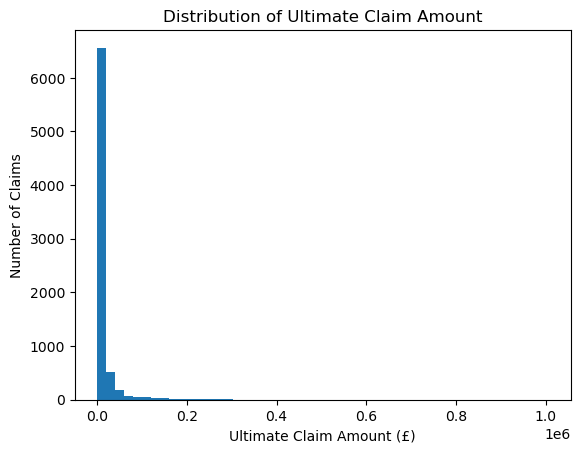

In [106]:

# Plot histogram of Ultimate Claim Amount
plt.figure()
plt.hist(
    claims_claim_level["Ultimate_Claim_Amount"],
    bins=50
)
plt.xlabel("Ultimate Claim Amount (£)")
plt.ylabel("Number of Claims")
plt.title("Distribution of Ultimate Claim Amount")
plt.show()



''' Strong right skew with a large number of small claims and long tail of very large claims.
This visualisation justifies using log transformation because without it, large claims will dominate the training and there will bw a problem of overfitting the scale.'''




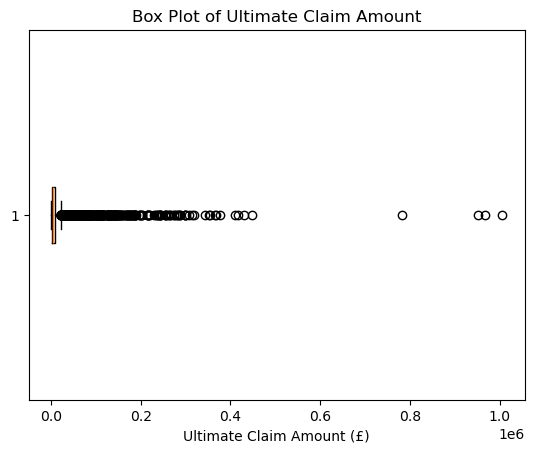

In [107]:
# Boxplot showing outliers

plt.figure()
plt.boxplot(
    claims_claim_level["Ultimate_Claim_Amount"],
    vert=False
)
plt.xlabel("Ultimate Claim Amount (£)")
plt.title("Box Plot of Ultimate Claim Amount")
plt.show()


'''This shows that most claims are relatively small. the long stretch of dots to the right confirms extreme right skew like we saw in the histplot.
it shows a heavy-tailed loss severity distribution with extreme but legitimate outliers supporting transformation rather than removal '''

In [114]:
# Confirm skew and scale before transforming

claims_claim_level[
    ["Ultimate_Claim_Amount"]
].describe()


,Ultimate_Claim_Amount
count,7.575000e+03
mean,1.311868e+04
std,3.810405e+04
min,3.320000e+02
25%,1.578000e+03
50%,3.409000e+03
75%,9.744000e+03
max,1.005590e+06


In [ ]:
''' count = 7,575 (Training population)
Minimum = £332 (confirms low-severity claims in the data)
25% of claims cost less than £1,578 (the lower end is tightly clustered)
50% of claims cost less than £3,409 (this represents typical claim not mean)
75% of claims cost less than £9,744
This means that most claims are less than £10k. therefore, highcost claims are relatively rare

Mean = £13,119 (average claim much less than median)
a small number of very large claims are pulling the average up

Standard Deviation = £38,104
The spread is 3x the mean. this signals huge variability and presence of extreme values

Maximum £1,8005,590
There are claims over £1million. this is why the mean is inflated.
They should not be considered errors but real business losses'''

In [118]:
# Apply log transformation 
''' Because ultimate claim amounts are heavily right-skewed with extreme but legitimate values,
    the application of log transformation is necessary to stabilise model learning while preserving
    relative cost differences '''

claims_claim_level["log_Ultimate_Claim_Amount"] = np.log1p(
    claims_claim_level["Ultimate_Claim_Amount"]
)

# log1p handles zero safely
# creates a new column and does not overwrite the original


In [121]:
# Verify Transformed Values

claims_claim_level[
    ["log_Ultimate_Claim_Amount"]
].describe()

# The mean and median are now closet together

,log_Ultimate_Claim_Amount
count,7575.000000
mean,8.383141
std,1.283887
min,5.808142
25%,7.364547
50%,8.134468
75%,9.184510
max,13.821086


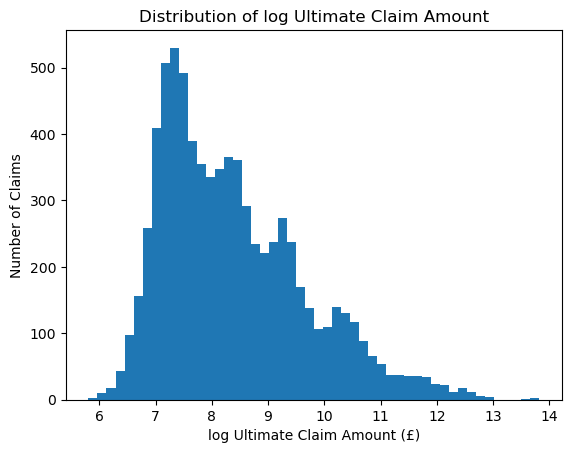

In [122]:
# Plot histogram of log_Ultimate_Claim_Amount

plt.figure()
plt.hist(
    claims_claim_level["log_Ultimate_Claim_Amount"],
    bins=50
)
plt.xlabel("log Ultimate Claim Amount (£)")
plt.ylabel("Number of Claims")
plt.title("Distribution of log Ultimate Claim Amount")
plt.show()


''' After log transformation, the ultimate claim amount shows a much more balanced distribution with reduced skew, 
    indicating that extreme claims are still represented but no longer dominate model learning'''



In [ ]:
''' Because the log transformation sufficiently stabilised the distribution, 
    preserved tail behaviour, and reduced skew 
    additional Winsorisation was not applied'''

### Sanity Check

Validation to ensure data structure, scale and meaning remain correct.


In [123]:
claims_claim_level["log_Ultimate_Claim_Amount"].isna().sum()

np.int64(0)

### Cleaned Dataset

Save Cleaned dataset

In [127]:
claims_claim_level.to_csv("Cleaned_claims_dataset.csv", index=False)